In [16]:
#STEP 1. — IMPORT LIBRARIES

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence


### German Dataset for a Mini-Transformer

In [17]:

#STEP 2️. — DEFINE A SMALL PARALLEL DATASET
#Each tuple represents (English sentence, German translation)
# This is a *dummy dataset for learning how translation models work.

data = [
    ("clear sky", "klarer himmel"),
    ("heavy rain", "starker regen"),
    ("light snow", "leichter schnee"),
    ("storm coming", "sturm kommt"),
    ("fog ahead", "nebel voraus")
]


#STEP 3️. — BUILD VOCABULARY

def build_vocab(sentences):
    # Start with 3 special tokens common in NLP
    tokens = {
        "<pad>": 0,   # padding token
        "<bos>": 1,   # beginning of sequence
        "<eos>": 2    # end of sequence
    }

    # Loop over each word in all sentences
    for s in sentences:
        for w in s.split():   # split sentence into words
            if w not in tokens:
                # Assign a new integer ID to unseen words
                tokens[w] = len(tokens)

    return tokens

# Build separate vocabularies for English (source) and German (target)
src_vocab = build_vocab([s for s, _ in data])
tgt_vocab = build_vocab([t for _, t in data])

# Example:
# src_vocab might look like:
# {'<pad>':0, '<bos>':1, '<eos>':2, 'clear':3, 'sky':4, 'heavy':5, 'rain':6, ...}


#STEP 4️. — ENCODE SENTENCES INTO TENSORS

def encode(sentence, vocab):
    """
    Convert a text sentence into a tensor of token IDs.
    Adds <bos> and <eos> tokens.
    Example:
        "heavy rain" -> [1, 5, 6, 2]
    """
    return torch.tensor(
        [vocab["<bos>"]] + [vocab[w] for w in sentence.split()] + [vocab["<eos>"]]
    )

# Apply encoding to every pair of sentences
src_seqs = [encode(s, src_vocab) for s, _ in data]
tgt_seqs = [encode(t, tgt_vocab) for _, t in data]

# Models expect tensors of equal shape in a batch.
# pad_sequence adds <pad> tokens to shorter sentences.
# Example:
#   Sentences of different lengths → padded to max length.
src_batch = pad_sequence(src_seqs, batch_first=True, padding_value=src_vocab["<pad>"])
tgt_batch = pad_sequence(tgt_seqs, batch_first=True, padding_value=tgt_vocab["<pad>"])


print("SRC vocab:", src_vocab)
print("TGT vocab:", tgt_vocab)
print("SRC batch shape:", src_batch.shape)
print("TGT batch shape:", tgt_batch.shape)


SRC vocab: {'<pad>': 0, '<bos>': 1, '<eos>': 2, 'clear': 3, 'sky': 4, 'heavy': 5, 'rain': 6, 'light': 7, 'snow': 8, 'storm': 9, 'coming': 10, 'fog': 11, 'ahead': 12}
TGT vocab: {'<pad>': 0, '<bos>': 1, '<eos>': 2, 'klarer': 3, 'himmel': 4, 'starker': 5, 'regen': 6, 'leichter': 7, 'schnee': 8, 'sturm': 9, 'kommt': 10, 'nebel': 11, 'voraus': 12}
SRC batch shape: torch.Size([5, 4])
TGT batch shape: torch.Size([5, 4])


### Positional Encoding

Why Do We Need This?

Transformers don’t process words sequentially (like RNNs do).
Instead, they read all tokens in parallel — which means we must give the model an explicit signal about word order.

So we add two things:
1. Word Embeddings → turn words into dense numeric vectors
2. Positional Encodings → inject order information (using sine/cosine patterns)

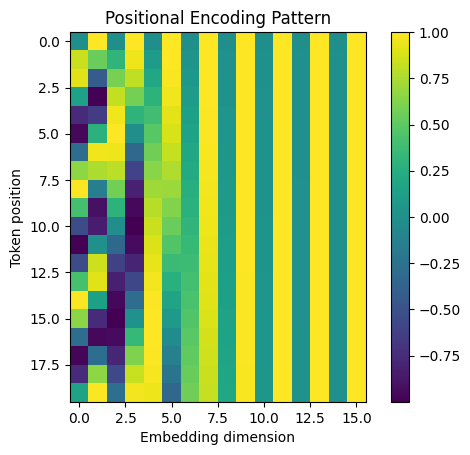

In [18]:
import math

def positional_encoding(seq_len, d_model):
    """
    Generates sinusoidal positional encodings for each position in a sequence.

    seq_len : number of tokens in the input sentence
    d_model : embedding dimension (e.g., 32, 64, 512, etc.)

    Returns: Tensor of shape (seq_len, d_model)
    """
    # Create an empty matrix to hold position encodings
    pe = torch.zeros(seq_len, d_model)

   # Position indices: [0, 1, 2, 3, ..., seq_len-1]
    pos = torch.arange(0, seq_len).unsqueeze(1)

    # Compute scaling factor for sine/cosine frequencies
    # Each even dimension uses a different frequency to encode order
    div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0)/d_model))

    # Apply sine to even dimensions, cosine to odd dimensions
    # Broadcasting: pos * div expands to (seq_len, d_model/2)
    pe[:, 0::2] = torch.sin(pos * div) # even indices: 0, 2, 4, ...
    pe[:, 1::2] = torch.cos(pos * div) # odd indices: 1, 3, 5, ...
    return pe

import matplotlib.pyplot as plt

pe = positional_encoding(seq_len=20, d_model=16)
plt.imshow(pe, cmap='viridis')
plt.title("Positional Encoding Pattern")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.colorbar()
plt.show()


### Combine with Word Embeddings
define an Embedder class that adds both word and position embeddings.

In [19]:

class Embedder(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        # Create an embedding lookup table:
        # vocab_size = number of unique tokens
        # d_model    = size of each embedding vector
        self.emb = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        """
        x: tensor of token IDs (batch_size, seq_len)
        returns: tensor of combined embeddings (batch_size, seq_len, d_model)
        """

        # Determine how many tokens in this input
        seq_len = x.size(1)

        # Generate positional encodings for this sequence length
        pe = positional_encoding(seq_len, self.emb.embedding_dim).to(x.device)

        # Add positional encoding to word embeddings
        # (broadcasting: pe has shape [seq_len, d_model], add to batch)
        return self.emb(x) + pe.unsqueeze(0)



### Multi-Head Self-Attention

## Scaled Dot-Product Attention 

After obtaining embeddings (semantic + positional), each token
now learns how to attend to other tokens in the same sentence.

At its core, **attention** computes a weighted sum of values based on the similarity between queries and keys:

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
$$

---

### Term Definitions

| Symbol | Meaning |
|:-------|:---------|
| **Q (Query)** | The current word’s “question” about the context |
| **K (Key)**   | Descriptions (features) of all words in the sequence |
| **V (Value)** | The actual information content to be retrieved |
| **dₖ**        | Dimensionality of the key vectors (used for scaling to prevent large dot products) |

---

### Intuition
1. Compute **similarity** between each Query and all Keys (`QKᵀ`).  
2. **Scale** by √dₖ to stabilize gradients.  
3. Apply **softmax** to get attention weights (probabilities).  
4. Use these weights to take a **weighted sum of Values (V)** — focusing on the most relevant tokens.


In [20]:

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute scaled dot-product attention.

    Parameters
    ----------
    Q : torch.Tensor
        Queries — what each token is asking for context.
        Shape: (batch, seq_len_q, d_k)
    K : torch.Tensor
        Keys — what each token offers for context.
        Shape: (batch, seq_len_k, d_k)
    V : torch.Tensor
        Values — actual information carried by tokens.
        Shape: (batch, seq_len_v, d_v)
    mask : torch.Tensor or None
        Optional tensor to mask out certain positions
        (e.g., padding or future tokens in the decoder).

    Returns
    -------
    out : torch.Tensor
        Contextualized representations of the same shape as V.
        Shape: (batch, seq_len_q, d_v)
    attn_weights : torch.Tensor
        Attention weights — how strongly each query attends
        to every key.
        Shape: (batch, seq_len_q, seq_len_k)
    """

    # Each query compares itself with all keys via dot product.
    # Scaling by sqrt(d_k) prevents excessively large gradients.
    d_k = Q.size(-1)
    scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)
    # → shape: (batch, seq_len_q, seq_len_k)


    # Apply optional mask (for padding or look-ahead masking)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Convert scores into probabilities using softmax
   
    attn_weights = F.softmax(scores, dim=-1)
    # Each row (per query) sums to 1.

  
    # Multiply attention weights by the Values (V)
    
    out = attn_weights @ V
    # → shape: (batch, seq_len_q, d_v)
    # Each token now becomes a weighted sum of all tokens’ values.

    return out, attn_weights


In [21]:
import torch
from torch import nn

class MiniEncoder(nn.Module):
    def __init__(self, d_model=32, nhead=2, dim_ff=64):
        super().__init__()

        # Self-Attention sublayer
        # Define a Multi-Head Attention layer
        #Multi-Head Self-Attention: input attends to itself
        # d_model = embedding dimension, nhead = number of heads
       
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        # Layer Normalizations 
        self.norm1 = nn.LayerNorm(d_model)

        # Feed-Forward sublayer
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff), ## expand representation
            nn.ReLU(),
            nn.Linear(dim_ff, d_model) ## project back to original dimension
        )
        ## Layer Normalizations 
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        x: (batch, seq_len, d_model)
        returns: (batch, seq_len, d_model)
        """

        # ---------------------------------------------------------
        # Self-Attention + Residual + LayerNorm
        # ---------------------------------------------------------

        #Each token attends to every other token in the same sentence
        attn_out, attn_weights = self.self_attn(x, x, x)
        x = self.norm1(x + attn_out)

        # ---------------------------------------------------------
        # Feed-Forward + Residual + LayerNorm
        # ---------------------------------------------------------
        ff_out = self.ff(x)
        # Add & Normalize (residual connection)
        x = self.norm2(x + ff_out)

        # return both the encoded output and attention weights 

        return x, attn_weights


In [39]:
import torch
from torch import nn

class MiniDecoder(nn.Module):
    def __init__(self, d_model=32, nhead=2, dim_ff=64):
        super().__init__()

        # ---------------------------------------------------------
        # Self-Attention (decoder attends to its own output)
        # ---------------------------------------------------------
        self.self_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)

        # ---------------------------------------------------------
        # Cross-Attention (decoder attends to encoder output)
        # ---------------------------------------------------------
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, batch_first=True)
        self.norm2 = nn.LayerNorm(d_model)

        # ---------------------------------------------------------
        # Feed-Forward Network
        # ---------------------------------------------------------
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, d_model)
        )
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory):
        """
        tgt: (batch, tgt_len, d_model)   — decoder input embeddings
        memory: (batch, src_len, d_model) — encoder output (context)
        returns:
            output: (batch, tgt_len, d_model)
            attn_maps: (self_attention, cross_attention)
        """

        # ---------------------------------------------------------
        # SELF-ATTENTION (within decoder)
        # ---------------------------------------------------------
        # Each token attends to previous tokens — allows autoregression.
        self_attn_out, self_attn_weights = self.self_attn(tgt, tgt, tgt)
        tgt = self.norm1(tgt + self_attn_out)

        # ---------------------------------------------------------
        # CROSS-ATTENTION (decoder ↔ encoder)
        # ---------------------------------------------------------
        # Each decoder token looks at all encoder outputs to decide
        # which parts of the input are relevant for generating the next word.
        cross_attn_out, cross_attn_weights = self.cross_attn(tgt, memory, memory)
        tgt = self.norm2(tgt + cross_attn_out)

        # ---------------------------------------------------------
        # FEED-FORWARD (position-wise)
        # ---------------------------------------------------------
        ff_out = self.ff(tgt)
        tgt = self.norm3(tgt + ff_out)

        return tgt, self_attn_weights, cross_attn_weights


### TinyTransformer — Full Encoder–Decoder Model


This class connects all the components:
1. Source input → Encoder → Context representations
2. Target input → Decoder (with cross-attention)
3. Decoder output → Linear layer → Vocabulary logits

In [51]:
class TinyTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=32, nhead=2):
        super().__init__()

        # Embedding layers for source and target
        self.src_emb = Embedder(src_vocab_size, d_model)
        self.tgt_emb = Embedder(tgt_vocab_size, d_model)

        # Encoder and Decoder
        self.encoder = MiniEncoder(d_model, nhead)
        self.decoder = MiniDecoder(d_model, nhead)

        # Final linear layer maps decoder outputs to target vocabulary
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        """
        src : (batch, src_len) — source token IDs
        tgt : (batch, tgt_len) — target token IDs (shifted during training)
        """

        # 1Embedding with positional encoding
        src_emb = self.src_emb(src)
        tgt_emb = self.tgt_emb(tgt)

        # Encoder output — returns (encoded_tensor, attn_weights)
        memory, _ = self.encoder(src_emb)  

        # Decoder attends to encoder memory
        dec_out, self_attn, cross_attn = self.decoder(tgt_emb, memory)

        # Map to vocabulary logits
        return self.fc_out(dec_out), (self_attn, cross_attn)


In [52]:
# Assume you already have:
# - src_vocab, tgt_vocab built
# - src_batch, tgt_batch tensors created
# - and TinyTransformer, MiniEncoder, MiniDecoder, Embedder classes defined

# Instantiate model
model = TinyTransformer(len(src_vocab), len(tgt_vocab))

# Forward pass
# Note: we shift the target input by 1 (teacher forcing)
#   tgt_batch[:, :-1] = all target tokens except <eos>
#   tgt_batch[:, 1:]  = true labels for loss computation later
logits, attn = model(src_batch, tgt_batch[:, :-1])

# Inspect outputs
print("Logits shape:", logits.shape)        # (batch, tgt_seq_len, tgt_vocab_size)
print("Cross-attention pattern:\n", torch.round(attn[0].detach(), decimals=2))



Logits shape: torch.Size([5, 3, 13])
Cross-attention pattern:
 tensor([[[0.3400, 0.2400, 0.4200],
         [0.4200, 0.2200, 0.3600],
         [0.4100, 0.2300, 0.3600]],

        [[0.4000, 0.3400, 0.2600],
         [0.4000, 0.2100, 0.3900],
         [0.2800, 0.4000, 0.3200]],

        [[0.2700, 0.4200, 0.3100],
         [0.3500, 0.4300, 0.2100],
         [0.3900, 0.3400, 0.2700]],

        [[0.3700, 0.2200, 0.4200],
         [0.3300, 0.2600, 0.4100],
         [0.5600, 0.2200, 0.2200]],

        [[0.3000, 0.5400, 0.1600],
         [0.2000, 0.7100, 0.0900],
         [0.3700, 0.5700, 0.0600]]])


In [53]:
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(50):
    optimizer.zero_grad()                       # 1️⃣ Reset gradients
    output, _ = model(src_batch, tgt_batch[:, :-1])  # 2️⃣ Forward pass (shifted target)
    
    # ---------------------------------------------------------
    # Compute loss
    # ---------------------------------------------------------
    # - output: (batch, tgt_len-1, vocab_size)
    # - tgt_batch[:, 1:]: target labels shifted by 1
    loss = criterion(
        output.reshape(-1, output.size(-1)),    # flatten predictions
        tgt_batch[:, 1:].reshape(-1)            # flatten targets
    )
    
    # ---------------------------------------------------------
    # Backpropagation
    # ---------------------------------------------------------
    loss.backward()          # compute gradients
    optimizer.step()         # update model weights

    # ---------------------------------------------------------
    #  Log progress every 10 epochs
    # ---------------------------------------------------------
    if epoch % 10 == 0:
        print(f"Epoch {epoch:2d}: Loss = {loss.item():.4f}")



Epoch  0: Loss = 2.4234
Epoch 10: Loss = 0.1334
Epoch 20: Loss = 0.0153
Epoch 30: Loss = 0.0046
Epoch 40: Loss = 0.0023


In [54]:
# Recreate inverse vocabulary for decoding
inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}


In [57]:
def translate(sentence, model, src_vocab, tgt_vocab, inv_tgt_vocab, max_len=8):
    model.eval()
    with torch.no_grad():
        # -----------------------------------------------------
        #  Encode the source sentence
        # -----------------------------------------------------
        src = torch.tensor([[src_vocab.get(w, 0) for w in sentence.split()]])
        src = torch.cat([
            torch.tensor([[src_vocab["<bos>"]]]),
            src,
            torch.tensor([[src_vocab["<eos>"]]])
        ], dim=1)
        src_emb = model.src_emb(src)
        memory, _ = model.encoder(src_emb)

        # -----------------------------------------------------
        # Start decoding
        # -----------------------------------------------------
        tgt = torch.tensor([[tgt_vocab["<bos>"]]])

        for _ in range(max_len):
            tgt_emb = model.tgt_emb(tgt)
            dec_out, self_attn, cross_attn = model.decoder(tgt_emb, memory)  # 👈 fix
            logits = model.fc_out(dec_out[:, -1])
            next_token = torch.argmax(logits, dim=-1).item()
            tgt = torch.cat([tgt, torch.tensor([[next_token]])], dim=1)

            if next_token == tgt_vocab["<eos>"]:
                break

        words = [inv_tgt_vocab[i.item()] for i in tgt[0][1:] if i.item() != tgt_vocab["<eos>"]]
        return " ".join(words)


In [58]:
print("English → German (model predictions):")
print("heavy rain →", translate("heavy rain", model, src_vocab, tgt_vocab, inv_tgt_vocab))
print("fog ahead →", translate("fog ahead", model, src_vocab, tgt_vocab, inv_tgt_vocab))
print("light snow →", translate("light snow", model, src_vocab, tgt_vocab, inv_tgt_vocab))


English → German (model predictions):
heavy rain → starker regen
fog ahead → nebel voraus
light snow → leichter schnee
